# Train the Sentiment Analysis Model

In [1]:
import os as os
import os.path

from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

from keras.models import Sequential, load_model
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.callbacks import History
from keras.utils import normalize

import numpy as np
import pickle
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import re as re
from random import randint
from gensim.models import KeyedVectors

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
HOME_DIR = os.path.expanduser('~')
DATA_DIR = os.path.join(HOME_DIR, '.ipublia', 'data')

SETTINGS = {
    'en': {
        'dataset': 'aclImdb',
        'dataset_dir': os.path.join(DATA_DIR, 'aclImdb'),
        'max-number-pos': 25000,
        'max-number-neg': 25000,
        'test-size': 0.5,
        'version': '1.0.0'
    },
    'de': {
        'dataset': 'filmstarts',
        'dataset_dir': os.path.join(DATA_DIR, 'filmstarts'),
        'max-number-pos': 25000,
        'max-number-neg': 15500,
        'test-size': 0.3,
        'version': '1.0.0'
    },
    'fr': {
        'dataset': 'allocine',
        'dataset_dir': os.path.join(DATA_DIR, 'allocine'),
        'max-number-pos': 25000,
        'max-number-neg': 25000,
        'test-size': 0.5,
        'version': '1.0.0'
    }
}

LANG = 'fr'
CONFIG = SETTINGS[LANG]

DATASET = CONFIG['dataset']
DATASET_DIR = CONFIG['dataset_dir']
MAX_NUMBER_POS = CONFIG['max-number-pos']
MAX_NUMBER_NEG = CONFIG['max-number-neg']
TEST_SIZE = CONFIG['test-size']
MODEL_NAME = 'sentiment-analysis'
MODEL_VERSION = CONFIG['version']

MODEL_FILE = os.path.join(DATA_DIR, MODEL_NAME, 'model_' + LANG + '_' + MODEL_VERSION + '.h5')
TOKENIZER_FILE = os.path.join(DATA_DIR, MODEL_NAME, 'tokenizer_' + LANG + '_' + MODEL_VERSION + '.pickle')
HISTORY_FILE = os.path.join(DATA_DIR, MODEL_NAME, 'history_' + LANG + '_' + MODEL_VERSION + '.pickle')
EMBEDDING_FILE = os.path.join(DATA_DIR, 'facebookresearch', 'wiki.' + LANG + '.vec')

MAX_WORDS = None
MIN_TEXT_LENGTH = 3
MAX_TEXT_LENGTH = 400

print('LANG: {}'.format(LANG))
print('EMBEDDING_FILE: {}\nMODEL_FILE: {}'.format(EMBEDDING_FILE, MODEL_FILE))
print('CONFIG', CONFIG)

LANG: fr
EMBEDDING_FILE: /Users/thomy/.ipublia/data/facebookresearch/wiki.fr.vec
MODEL_FILE: /Users/thomy/.ipublia/data/sentiment-analysis/model_fr_1.0.0.h5
CONFIG {'dataset': 'allocine', 'dataset_dir': '/Users/thomy/.ipublia/data/allocine', 'max-number-pos': 25000, 'max-number-neg': 25000, 'test-size': 0.5, 'version': '1.0.0'}


In [3]:
def load_word_embedding(file, max_words=None):    
    embedding_index = {}
    model = KeyedVectors.load_word2vec_format(file, limit=max_words)
    
    for word in model.vocab:
        embedding_index[word] = model[word]
        
    embedding_dimension = 300 #len(next (iter (embedding_index.values())))
    return (embedding_index, embedding_dimension)

In [4]:
def clean_text(text):
    text = text.lower()
    text = re.sub('<br />', '', text)
    text = re.sub('(\n|\r|\t)+', ' ', text)
    text = re.sub('ß', 'ss', text)
    text = re.sub('’', "'", text)
    text = re.sub('[^a-zA-Z0-9.!?,;:\-\' äàâæçéèêîïíìöôóòœüûüúùÿ]+', '', text)
    text = re.sub(' +', ' ', text)
    return text

In [5]:
def load_data(dataset_path,
              max_number_pos=100,
              max_number_neg=100,
              min_words=None,
              max_words=None,
              clean=False,
              shuffle=False):
    
    def load(path, y_val, max_number):
        
        x = np.array([])
        y = np.array([])
        
        files = [str(os.path.join(path, f)) for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
        loaded_count = 0
        
        for file in files:
            
            if loaded_count == max_number:
                break
                
            with open(file, 'r', encoding='utf-8') as f:
                text = f.readline()
                if clean:
                    text = clean_text(text)
                
                splitted = text.split(' ')
                if min_words and len(splitted) < min_words:
                    continue

                if max_words:
                    text = ' '.join(splitted[:max_words])

                x = np.append(x, text)
                y = np.append(y, y_val)
                loaded_count += 1 
                
            if loaded_count % 1000 == 0:
                print('  {} items loaded...'.format(loaded_count))
        
        return (x, y)

    print('Loading data from {}'.format(dataset_path))
    x = np.array([])
    y = np.array([])
    
    if DATASET == 'aclImdb':
        print('Using train/test source data structure.')
        print('Loading {} pos items...'.format(max_number_pos))
        x_pos, y_pos = load(os.path.join(dataset_path, 'train', 'pos'), 1, max_number_pos)
        x = np.append(x, x_pos)
        y = np.append(y, y_pos)
        
        x_pos, y_pos = load(os.path.join(dataset_path, 'test', 'pos'), 1, max_number_pos - len(x_pos))
        x = np.append(x, x_pos)
        y = np.append(y, y_pos)
        
        print('Loading {} neg items...'.format(max_number_neg))
        x_neg, y_neg = load(os.path.join(dataset_path, 'train', 'neg'), 0, max_number_neg)
        x = np.append(x, x_neg)
        y = np.append(y, y_neg)
        
        x_neg, y_neg = load(os.path.join(dataset_path, 'test', 'neg'), 0, max_number_neg - len(x_neg))
        x = np.append(x, x_neg)
        y = np.append(y, y_neg)
        
    else:
        print('Using pos/neg source data structure.')
        print('Loading {} pos items...'.format(max_number_pos))
        x_pos, y_pos = load(os.path.join(dataset_path, 'pos'), 1, max_number_pos)
        x = np.append(x, x_pos)
        y = np.append(y, y_pos)

        print('Loading {} neg items...'.format(max_number_neg))
        x_neg, y_neg = load(os.path.join(dataset_path, 'neg'), 0, max_number_neg)
        x = np.append(x, x_neg)
        y = np.append(y, y_neg)
    
    print('Loaded {} items.'.format(len(x)))
    
    if shuffle:
        print('Shuffling items...')
        p = np.random.permutation(len(x))
        x = x[p]
        y = y[p]
        
    return (x, y)

## Load and Preprocess the Training and Test Data

In [7]:
(x, y) = load_data(DATASET_DIR,
                   max_number_pos=MAX_NUMBER_POS,
                   max_number_neg=MAX_NUMBER_NEG,
                   min_words=MIN_TEXT_LENGTH,
                   max_words=MAX_TEXT_LENGTH,
                   clean=True,
                   shuffle=True)

print('Loaded {} items.'.format(len(x)))

Loading data from /Users/thomy/.ipublia/data/allocine
Using pos/neg source data structure.
Loading 25000 pos items...
  1000 items loaded...
  2000 items loaded...
  3000 items loaded...
  4000 items loaded...
  5000 items loaded...
  6000 items loaded...
  7000 items loaded...
  8000 items loaded...
  9000 items loaded...
  10000 items loaded...
  11000 items loaded...
  12000 items loaded...
  13000 items loaded...
  14000 items loaded...
  15000 items loaded...
  16000 items loaded...
  17000 items loaded...
  18000 items loaded...
  19000 items loaded...
  20000 items loaded...
  21000 items loaded...
  22000 items loaded...
  23000 items loaded...
  24000 items loaded...
  25000 items loaded...
Loading 25000 neg items...
  1000 items loaded...
  2000 items loaded...
  3000 items loaded...
  4000 items loaded...
  5000 items loaded...
  6000 items loaded...
  7000 items loaded...
  8000 items loaded...
  9000 items loaded...
  10000 items loaded...
  11000 items loaded...
  12000 i

In [8]:
print('Splitting into train and test sets ...')
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=TEST_SIZE, random_state=0)

del x
del y

print('Shape x_train: {}, y_train: {}'.format(x_train.shape, y_train.shape))
print('      x_test: {}, y_test: {}'.format(x_test.shape, y_test.shape))

print('Creating tokenizer ...')
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(x_train)

word_index = tokenizer.word_index
print('    Found {} unique tokens.'.format(len(word_index)))

print('Vectorizing sequence data ...')
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

print('Padding sequence data ...')
x_train = pad_sequences(x_train, maxlen=MAX_TEXT_LENGTH)
x_test = pad_sequences(x_test, maxlen=MAX_TEXT_LENGTH)

print('Normalizing sequence data ...')
#x_train = normalize(x_train.astype(np.float32))
#x_test = normalize(x_test.astype(np.float32))
x_train = x_train.astype(np.float64)
x_test = x_test.astype(np.float64)
# print(x_train[0:1][0:10])

print('Done.')

Splitting into train and test sets ...
Shape x_train: (25000,), y_train: (25000,)
      x_test: (25000,), y_test: (25000,)
Creating tokenizer ...
    Found 48222 unique tokens.
Vectorizing sequence data ...
Padding sequence data ...
Normalizing sequence data ...
Done.


In [ ]:
# Test
for i in range(0, 5):
    j = np.random.randint(0, len(x_train))
    print(x_train[j][-10:], '\nrating:', y_train[j], '  index:', j, '\n')

## Load the Word Embeddings

In [9]:
(embedding_index, embedding_dimension) = load_word_embedding(EMBEDDING_FILE, MAX_WORDS)

In [10]:
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dimension))
matches = 0
for word, i in tokenizer.word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        matches += 1
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        
print('Length of embedding_matrix: {}, matches with embedding: {}, ratio: {:.4f}'.format(
    len(embedding_matrix), matches, matches / len(embedding_matrix)))

Length of embedding_matrix: 48223, matches with embedding: 36010, ratio: 0.7467


## Define the Model

In [11]:
model = Sequential()
model.add(
    Embedding(len(tokenizer.word_index) + 1,
              embedding_dimension,
              weights=[embedding_matrix],
              input_length=MAX_TEXT_LENGTH,
              trainable=False))

model.add(LSTM(400, dropout=0.4, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 400, 300)          14466900  
_________________________________________________________________
lstm_1 (LSTM)                (None, 400)               1121600   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 401       
Total params: 15,588,901
Trainable params: 1,122,001
Non-trainable params: 14,466,900
_________________________________________________________________


## Train the Model

In [12]:
BATCH_SIZE = 64
EPOCHS = 8

history = model.fit(
    x_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_test, y_test),
    verbose=1)

loss, acc = model.evaluate(
    x_test, y_test,
    batch_size=BATCH_SIZE,
    verbose=1)

print('Test loss:', loss)
print('Test acc:', acc)
print('Accuracy: {:.4f}'.format(acc*100))

Train on 25000 samples, validate on 25000 samples
Epoch 1/8
25000/25000 [==============================] - 2073s 83ms/step - loss: 0.6222 - acc: 0.6555 - val_loss: 0.5638 - val_acc: 0.7286
Epoch 2/8
25000/25000 [==============================] - 2095s 84ms/step - loss: 0.5548 - acc: 0.7167 - val_loss: 0.4793 - val_acc: 0.7731
Epoch 3/8
25000/25000 [==============================] - 2109s 84ms/step - loss: 0.4726 - acc: 0.7734 - val_loss: 0.4214 - val_acc: 0.8022
Epoch 4/8
25000/25000 [==============================] - 1990s 80ms/step - loss: 0.4334 - acc: 0.7942 - val_loss: 0.4054 - val_acc: 0.8150
Epoch 5/8
25000/25000 [==============================] - 2004s 80ms/step - loss: 0.4056 - acc: 0.8103 - val_loss: 0.3738 - val_acc: 0.8280
Epoch 6/8
25000/25000 [==============================] - 1990s 80ms/step - loss: 0.4131 - acc: 0.8072 - val_loss: 0.3768 - val_acc: 0.8273
Epoch 7/8
25000/25000 [==============================] - 2001s 80ms/step - loss: 0.3786 - acc: 0.8290 - val_loss: 0.

## Show Training History

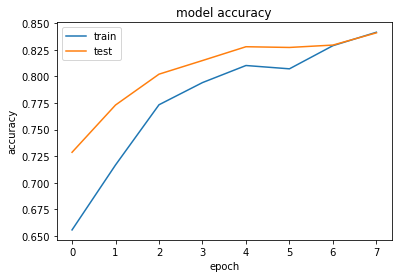

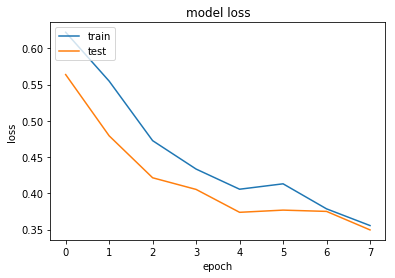

In [13]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Save Model, Tokenizer and History

In [14]:
model.save(MODEL_FILE)
# Store the tokenizer. The model can't be reused without it.
with open(TOKENIZER_FILE, 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open(HISTORY_FILE, 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Load Model, Tokenizer and History

In [ ]:
model = load_model(MODEL_FILE)
with open(TOKENIZER_FILE, 'rb') as handle:
    tokenizer = pickle.load(handle)

with open(HISTORY_FILE, 'rb') as handle:
    history = History()
    history.history = pickle.load(handle)

## Predict

In [ ]:
(x_train, y_train, x_test, y_test) = load_data(TRAIN_AND_TEST_DATA_DIR)

In [ ]:
def count(a):
    count = [0, 0]
    for i in range(len(a)):
        if(a[i] == 1):
            count[0] += 1
        else:
            count[1] += 1
    return count

print(len(y_train), len(y_test))
print('pos/neg', count(y_train), count(y_test))

In [ ]:
float_formatter = lambda x: "%.4f" % x

for i in range(0, 9):
    sample_index = randint(0, len(x_test))
    reviews = [x_test[sample_index]]
    sequences = tokenizer.texts_to_sequences(reviews)
    padded_reviews = pad_sequences(sequences, maxlen=MAX_TEXT_LENGTH)
    pred = model.predict(np.array(padded_reviews))[0][0]
    
    print(sample_index, ':', round(pred) == y_test[sample_index], float_formatter(pred), y_test[sample_index], reviews[0][0:500])
    print() 

In [16]:
reviews = [
    'Habe den Film gestern in der Cinelady-Vorstellung gesehen und war enttäuscht. Es wird extrem oberflächlich eine dem Thema nicht gerecht werdende Story ohne jeden Höhepunkt erzählt.',
    'Dieser Film ist allen Menschen zu empfehlen, die sich für die Tragik der Liebe und für tiefgehende Dialoge und Gefühle interessieren.',
    'Dieser Film ist vom Anfang bis am Ende spannend! Die Schauspieler sind super!',
    'Dieser Film ist vom Anfang bis am Ende langweilig! Die Schauspieler sind mässig bis schlecht!',
    'Ein super Film, überhaupt nicht wertend sondern extrem informativ und spannend wie unsere Politik funktioniert!',
    'Eine sehr einseitige Dokumentation. Nicht empfehlenswert!',
    'Wunder ist ein Wunderbarer Film mit einem grandiosen Darsteller-Cast bei dem kein Auge trocken bleibt.Köstlich für alle Star Wars Fans sind die liebevollen Anspielung auf Star Wars die im Film vorkommen.Für alle Homeland Fans ist in einem kurz auftritt der Star aus dessen Serie Mandy Patinkin zu sehen.Sowie ist Wunder für den Oscar 2018 als bestes Make-up nominiert.Dafür gibts von Mir 4.1/2 Sterne von 5.',
    'Kann ausnahmsweise der Cinema-Kritik absolut recht geben. Alle Figuren unglaubwürdig, übertrieben und jedes Klischee verwendet. Aber heute reicht es scheinbar, wenn es laut ist und viele Leute völlig unnötig niedergemetzelt werden - Logik braucht es dazu nicht. Schade!!',
    'Das Rundumpacket ist super. Leider ist der Monitor mit dem GSync Modul nochmals knappe 100.- teurer, sodass ich selber nicht von dem FreeSync Modul profitieren kann, da ich eine NVidia Grafikkarte besitze. Die 240 Hz sind echt spürbar im Shooterbereich. Die Farben kommen trotz dem TN Panel gut rüber. Für den Durchschnittspieler sind die 240 Hz überflüssig. Aber wenn man sich im eSports aufhält, können diese echt etwas ausmachen.',
    'Mit diesen BT-Kopfhörern bin ich nur mittelmässig zufrieden. Die BOSE SoundSport Wireless sind meine 3. BT-Kopfhörer in nur 2 Jahren. Bislang war ich in der Preisklasse um die 100 CHF unterwegs. Nachdem BT In-Ears nun schon seit 3 Jahren auf dem Markt sind, wollte ich etwas mehr investieren und habe mich anhand anderer Bewertungen (leider) für die SoundSport entschieden. Zu den Produkteigenschaften: Der Klang ist super, die Bässe total präzise. Die maximale Lautstärke hingegen könnte noch mehr sein. Manchmal braucht man das halt. Das Gehäuse ist nicht vollständig geschlossen, da kommen Umgebungsgeräusche durch, denn die Silikon-Pads sind nicht ganz dicht. Überhaupt die Silikon-Pads! Normalerweise habe ich bei den Grösse M, bei den SoundSport aber L. Immerhin: sie sitzen bombenfest und drücken konstruktionsbedingt kein bisschen. Aber: für Menschen mit grossen Ohren könnte L zu klein sein. Die Verbindungsqualität ist exzellent. Die SoundSport connecten super schnell und die Verbindung ist äusserst stabil. Kein Ruckeln in der Übertragung, selbst wenn das Natel in der Hosentasche steckt. Ebenfalls super ist die Ladegeschwindigkeit mit ca. 1.5 Stunden wenn die Akkus komplett leer sind. Die Akkus halten bei mir aber nicht 8h, sondern nur ca. 4h, Lautstärke liegt meist bei 80%. Ein nettes Feature ist die Ladezustandsansage beim Anschalten. Blöd ist nur, dass die Restlaufzeit nach der Warnmeldung "Batterieladezustand niedrig" nur noch 5-10 Minuten beträgt. Was jetzt noch bleibt sind die Bedienelemente. An-/Ausschalter befinden sich direkt am rechten Ear-Plug. Laut/Leise/Start/Stop und Mikro sind im Bedienelement am Kabel untergebracht, aber die Druckpunkte sind unterirdisch! Vor/Zurück gibts nicht (oder funzt nicht mit meinem HTC one), man muss in dem Fall immer das Natel/MP3-Player rausholen. Alles in einem einzigen Bedienelement unterzubringen, inkl. Skip-Funktion, ist doch längst Standard.',
    'Etwas gross aber mit spitzen Klang und Tragekomfort. Verbindet schnell und stabil via Bluetooth. Ich hatte schon einige bluetooth in-ohr Kopfhörer aber dieser Bose ist bei weitem der Beste.'
]

reviews = [
    'J\'aime ce film. Les acteurs jouent vraiment bien!',
    'Je n\'aime ce film. Les acteurs jouent vraiment mal!'
]

val = [
    0,
    1,
    1,
    0,
    1,
    0,
    1,
    0,
    1,
    1
]

sequences = tokenizer.texts_to_sequences(reviews)
padded_reviews = pad_sequences(sequences, maxlen=MAX_TEXT_LENGTH)
preds = model.predict(np.array(padded_reviews))

for i in range(len(preds)):
    print('{}, {:.4f}, {}, {}'.format(round(preds[i][0]) == val[i], preds[i][0], val[i], reviews[i][0:1000]))
    print()

False, 0.6140, 0, J'aime ce film. Les acteurs jouent vraiment bien!

False, 0.2705, 1, Je n'aime ce film. Les acteurs jouent vraiment mal!

